In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix

In [ ]:
train_file = 'fashion-mnist_train.csv'
test_file = 'fashion-mnist_test.csv'

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [ ]:
train_data.shape

(60000, 785)

In [ ]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_data.shape

(10000, 785)

In [ ]:
# Extraire les labels et les images
train_labels = train_data.iloc[:, 0].values  # La première colonne
train_images = train_data.iloc[:, 1:].values  # Les colonnes suivantes

test_labels = test_data.iloc[:, 0].values
test_images = test_data.iloc[:, 1:].values

In [ ]:
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28).astype('float32')  # Reshape en 28x28
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return torch.tensor(image), torch.tensor(label)


In [ ]:
# Normalisation des images et conversion en tenseurs
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir en tenseur (normalisation [0, 1])
    transforms.Normalize((0.5,), (0.5,))  # Optionnel : centrer les données autour de 0
])


In [ ]:
train_dataset = FashionMNISTDataset(train_images, train_labels, transform=transform)
test_dataset = FashionMNISTDataset(test_images, test_labels, transform=transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Taille des images : {images.shape}")  # torch.Size([64, 1, 28, 28])
print(f"Taille des labels : {labels.shape}")  # torch.Size([64])

Taille des images : torch.Size([64, 1, 28, 28])
Taille des labels : torch.Size([64])


In [ ]:
for i, (X_Train, y_train) in enumerate(train_dataset):
  break

In [ ]:
X_Train.shape

torch.Size([1, 28, 28])

In [ ]:

# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2

    # Re-View to flatten it out
    X = X.view(-1, 16*5*5) # negative one so that we can vary the batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [ ]:
# Create an Instance of our Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out some results
    if b % 600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad():
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


Epoch: 0  Batch: 600  Loss: 0.22882288694381714
Epoch: 1  Batch: 600  Loss: 0.4333483576774597
Epoch: 2  Batch: 600  Loss: 0.27227577567100525
Epoch: 3  Batch: 600  Loss: 0.4326816201210022
Epoch: 4  Batch: 600  Loss: 0.35798755288124084


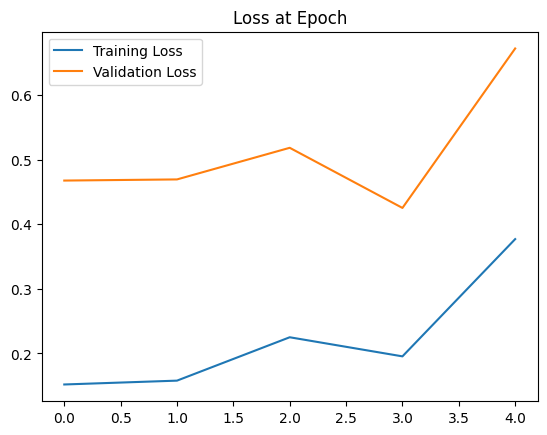

In [ ]:
# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

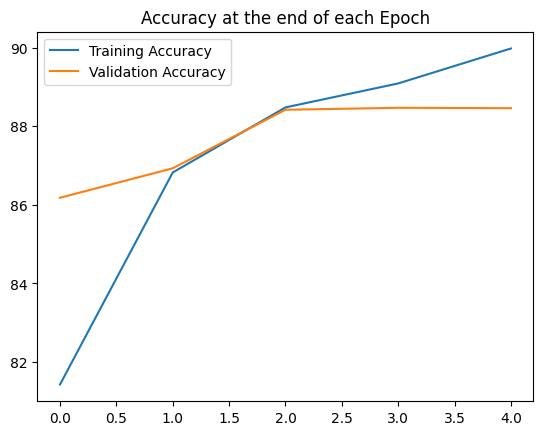

In [ ]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [ ]:
test_load = DataLoader(test_dataset, batch_size=10000, shuffle=False)

In [ ]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [ ]:
# Did for correct
correct.item()/len(test_data)*100

88.46000000000001

In [ ]:
test_dataset[4525]

(tensor([[[ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,   1.,  -1.,  -1.,
            47., 121.,  59.,  91., 111.,  -1.,  -1.,   1.,  -1.,  -1.,  -1.,
            -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
          [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
           225., 289., 247., 251., 337.,  83.,  -1.,  -1.,  -1.,  -1.,  -1.,
            -1.,   1.,  -1.,  -1.,  -1.,  -1.],
          [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,   1.,  71.,  57.,
           129., 509., 475., 449., 453.,  47., 145.,  57.,  -1.,  -1.,  -1.,
            -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
          [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  73., 103., 127.,  91.,
            -1., 361., 423., 405., 143.,  25., 131., 149., 131., 105.,  -1.,
            -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
          [ -1.,  -1.,  -1.,  -1.,  -1.,  -1., 103., 121.,  87.,  83.,  81.,
            41.,  43., 509., 303.,   3.,  65.,  63.,  89., 107., 179.,  67.,
            -1.,  -1.,  -1.,  -1.,  -1

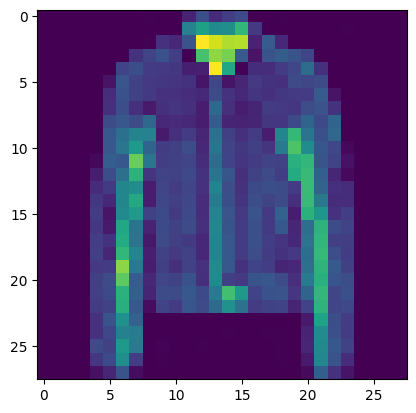

In [ ]:
# Show the image
plt.imshow(test_dataset[4525][0].reshape(28,28))

In [ ]:
# Pass the image thru our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_dataset[4525][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 image

In [ ]:
# Check the new prediction...get probabilities
new_prediction

tensor([[-1.4069e+01, -1.5712e+01, -7.0211e+00, -1.4637e+01, -2.3483e-03,
         -1.8875e+01, -6.5354e+00, -1.5950e+01, -1.6505e+01, -1.7589e+01]])

In [ ]:
new_prediction.argmax()

tensor(4)